## Variational Inference in Pyro on CIFAR 10

In [ ]:
#Paths
path_to_hw2 = "/content/drive/My Drive/PhD Classes/Graphical Models/Homework/hw2/ml-variational-inference-imaging"
cifar_path = "cifar-10-batches-py"

#### Google Drive Setup

Ensure that `path_to_hw2` is the correct path to your working directory. It should contain a subdirectory that holds the decompressed files from the CIFAR 10 dataset

In [ ]:
#Drive Setup (cuda)

import torch
assert(torch.cuda.is_available())
device = "cuda"

from google.colab import drive
drive.mount('/content/drive')

import os
path_to_batches = path_to_hw2 + "/" + cifar_path
batches = [file for file in sorted(os.listdir(path_to_batches)) if "batch" in file]
batches

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['batches.meta',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'test_batch']

### Data Pre-Processing

#### Unwrapping CIFAR 10 Python Dataset

CIFAR-10 contains 60K 32x32 images divided into 10 clusters. 
- `test_batch` contains 10K samples.
- `data_batch_{1...5}` contains 10K samples each, amounting to total of 50K samples.
- `batches.meta` contains information on the datasets

In [ ]:
import pickle
import os
import numpy

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

data_batches = list()
for i, batch in enumerate(batches):
    batch_path = os.path.join(path_to_batches, batch)
    data_batches.append(unpickle(batch_path))

    print(batch)
    print(data_batches[i].keys())

meta_data = data_batches[0]
training_data = data_batches[1:-1]
test_data = data_batches[-1]

batches.meta
dict_keys(['num_cases_per_batch', 'label_names', 'num_vis'])
data_batch_1
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_2
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_3
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_4
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_5
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
test_batch
dict_keys(['batch_label', 'labels', 'data', 'filenames'])


#### CIFAR 10 Databatch Breakdown

The data entry per databatch contains a 10000K samples x 3072 array. The 3072 array corresponds to each 32x32 color image (1024) with a row-major ordering of the 3 channels (R, G, B). 

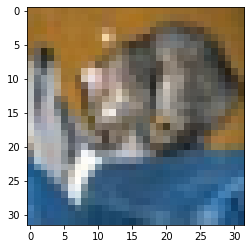

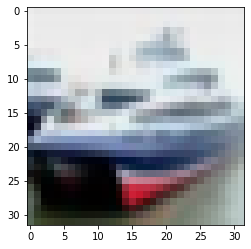

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#reshape image to be column order for output
def reshape(input_img):
  return np.transpose(np.reshape(input_img,(3, 32,32)), (1,2,0))

for single_img in test_data['data'][:2]:
  plt.figure()
  plt.imshow(reshape(single_img))

There are 10 labels shown below that correspond to each image. Hence, we use a mixed model to represent the clustering task since only one image can belong to one label. 

In [ ]:
num_cases_per_batch = meta_data['num_cases_per_batch']
num_vis = meta_data['num_vis']
label_names = meta_data['label_names']
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

#### Building 10-Cluster Mixed Model for Pyro VI

Installing pyro and building mixed model to perform variational inference

In [ ]:
!pip install pyro-ppl

import pyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 722 kB 8.4 MB/s 


In [ ]:
#import all necessary packages
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.2')
pyro.set_rng_seed(0)

In [ ]:
k = 10

def model(data):
    """
    Build Multivariate Gaussian Mixture Model

    <HYPERPARMETERS>
    alpha: Dirichlet concentration for mixture proportions
    eta: variance of each mixture component
    k: number of clusters/components
    image_dim: dimension of vector representation (3072)

    <MODEL>
    theta: mixture proportions defined by Dirichlet(alpha)
    beta: mixture components with parameters defined by Multivariate Normal
    z: latent cluster assignment defined by Categorical(theta)
    observations: sample from assigned component
   

    reference: https://docs.pyro.ai/en/dev/infer.autoguide.html#autodelta
    """

    # define the hyperparameters
    alpha = torch.tensor(0.5) 
    eta = pyro.sample('eta', LogNormal(0., 2.))
    n = torch.tensor(len(data)) 
    image_dim = 3*32*32

    #mixture proportions
    theta = pyro.sample("theta", Dirichlet(alpha*torch.ones(k)))

    #mixture components (multivariate Gaussians)
    with pyro.plate("components", k):
      #identity for correlation matrix to depict independent components
      beta = pyro.sample("beta", MultivariateNormal(torch.zeros(image_dim), eta*torch.eye(image_dim)))

    #cluster assignments and data
    with pyro.plate("data", n):
      z = pyro.sample("cluster_assignments", Categorical(theta))
      pyro.sample("obs", MultivariateNormal(beta[z], torch.eye(image_dim)), obs=data)


In [ ]:
#build auto guide (variational distribution)
from pyro.infer.autoguide import AutoDelta
from pyro import poutine

# def init_loc_fn(site):
#     if site["name"] == "theta":
#         return torch.ones(k) / k #uniform weights
#     elif site["name"] == "eta":
#         return (data.var() / 2).sqrt()
#     elif site["name"] == "beta":
#         return data[torch.multinomial(len(data)) / len(data), k)]
#     raise ValueError(site["name"])

auto_guide = AutoDelta(poutine.block(model, expose=['theta', 'beta', 'eta']))
        # ,init_loc_fn=init_loc_fn)

In [ ]:
data_batches[1]['data'][:200,].shape

(200, 3072)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19


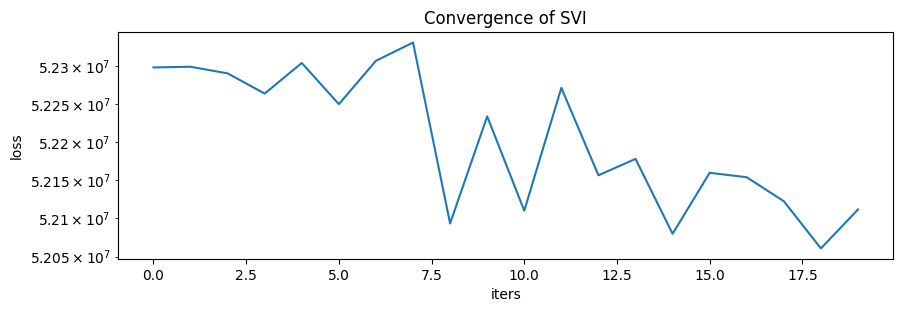

In [ ]:
#perform stochastic variational inference

adam_lr = 0.05
num_iters = 20

# set up the optimizer
adam_params = {"lr": adam_lr}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, auto_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

losses = []
training_data = torch.from_numpy(data_batches[1]['data'][:2,])
# do gradient steps
for step in range(num_iters):
    print("iteration {}".format(step))
    loss = svi.step(training_data)
    losses.append(loss)
  
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');
